In [16]:
%%time
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
device = torch.device("cuda")

df = pd.read_parquet('data.parquet')
X = torch.tensor(np.vstack(df['X']), device=device, dtype=torch.float32)
y = torch.tensor(df['y'].values, device=device, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
label_map = dict(enumerate(df['labels'].unique()))

CPU times: user 8.19 s, sys: 5.03 s, total: 13.2 s
Wall time: 9.21 s


Fold 1

Epoch [10/100]
  Train Accu: 86.83%
  Val Accu: 71.42%

Epoch [20/100]
  Train Accu: 97.13%
  Val Accu: 72.99%

Epoch [30/100]
  Train Accu: 98.51%
  Val Accu: 72.40%

Epoch [40/100]
  Train Accu: 98.83%
  Val Accu: 73.53%

Epoch [50/100]
  Train Accu: 98.99%
  Val Accu: 73.33%

Epoch [60/100]
  Train Accu: 99.22%
  Val Accu: 73.04%

Epoch [70/100]
  Train Accu: 99.34%
  Val Accu: 73.67%

Epoch [80/100]
  Train Accu: 99.40%
  Val Accu: 73.54%

Epoch [90/100]
  Train Accu: 99.38%
  Val Accu: 73.56%

Epoch [100/100]
  Train Accu: 99.66%
  Val Accu: 74.76%
Fold 2

Epoch [10/100]
  Train Accu: 87.89%
  Val Accu: 72.67%

Epoch [20/100]
  Train Accu: 97.01%
  Val Accu: 74.21%

Epoch [30/100]
  Train Accu: 98.62%
  Val Accu: 74.78%

Epoch [40/100]
  Train Accu: 99.23%
  Val Accu: 74.82%

Epoch [50/100]
  Train Accu: 98.90%
  Val Accu: 75.13%

Epoch [60/100]
  Train Accu: 99.30%
  Val Accu: 74.77%

Epoch [70/100]
  Train Accu: 99.44%
  Val Accu: 75.39%

Epoch [80/100]
  Train Accu: 99.

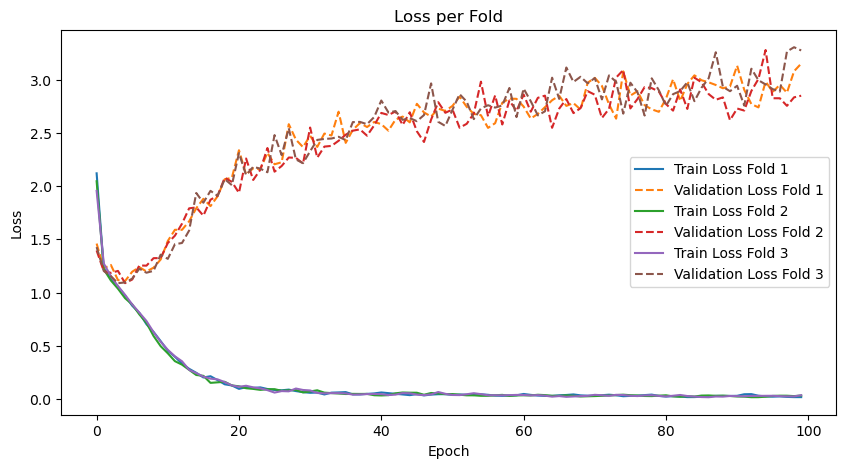

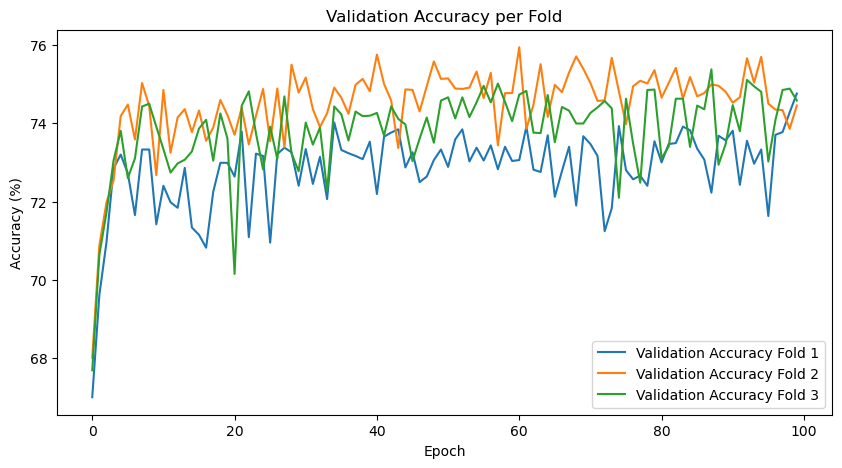

Fold 1 Test Accuracy: 75.40%
Fold 2 Test Accuracy: 74.54%
Fold 3 Test Accuracy: 74.91%
74.95056717660526


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from polyloss import Poly1CrossEntropyLoss
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset


class BasicBlock(nn.Module):

    def __init__(self, dim, kernel_size=9):
        super().__init__()

        self.Resnet = nn.Sequential(
            nn.Conv1d(dim,
                      dim,
                      kernel_size=kernel_size,
                      groups=dim,
                      padding='same'),
            nn.BatchNorm1d(dim),
            nn.GELU(),
        )

        self.Conv_1x1 = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=1),
            nn.BatchNorm1d(dim),
        )
        self.identity = nn.Identity()

    def forward(self, x):
        id = self.identity(x)
        x = self.Resnet(x)
        x = self.Conv_1x1(x)
        x = x + id
        x = F.gelu(x)

        return x


class Pace(nn.Module):

    def __init__(self,
                 dim=1024,
                 depth=4,
                 kernel_size=9,
                 patch_size=16,
                 pool_dim=256,
                 n_classes=len(label_map),
                 overlapped=False):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.pool_dim = pool_dim

        stride = patch_size // 2 if overlapped else patch_size
        self.spec_emb = nn.Sequential(
            nn.Conv1d(1, dim, kernel_size=patch_size, stride=stride),
            nn.BatchNorm1d(dim),
            nn.GELU(),
        )

        self.dropout = nn.Dropout(p=0.2)
        self.backbone = nn.ModuleList([])

        for _ in range(depth):
            self.backbone.append(BasicBlock(dim=dim, kernel_size=kernel_size))

        self.head = nn.Sequential(
            # nn.Linear(16*1024, 1),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            # nn.Linear(dim*(pool_dim//patch_size), n_classes)
            nn.Linear(dim, n_classes))

    def forward(self, x):
        x = F.adaptive_avg_pool1d(x, self.pool_dim)
        x = self.spec_emb(x)  # [B, dim, pool_dim // patch_size]
        x = self.dropout(x)
        for block in self.backbone:
            x = block(x)
        x = self.head(x)  # [B, 1024, 16]

        return x


batch_size = 512
num_epochs = 100
k_folds = 3
best_models = []
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []

kf = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kf.split(X_train)):
    best_val_loss = float('inf')
    best_model_state_dict = None
    print(f'Fold {fold + 1}')
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    # 创建训练和验证数据集
    X_train_fold = X_train[train_ids].unsqueeze(1)
    y_train_fold = y_train[train_ids]
    X_val_fold = X_train[val_ids].unsqueeze(1)
    y_val_fold = y_train[val_ids]

    # 转换为 DataLoader
    train_fold_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_fold_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_fold_loader = DataLoader(dataset=train_fold_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)
    val_fold_loader = DataLoader(dataset=val_fold_dataset,
                                 batch_size=batch_size,
                                 shuffle=False)

    model = Pace().to(device)
    criterion = Poly1CrossEntropyLoss(num_classes=len(label_map),
                                      epsilon=1.0,
                                      reduction='mean')
    # optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-6)
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for X_batch, y_batch in train_fold_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y_batch).sum().item()

        # 计算平均损失和准确率
        train_loss /= len(train_fold_loader)
        train_accuracy = 100 * train_correct / len(train_fold_dataset)
        epoch_train_losses.append(train_loss)
        epoch_train_accuracies.append(train_accuracy)

        # 评价2
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_fold_loader:
                X_val_batch, y_val_batch = X_val_batch.to(
                    device), y_val_batch.to(device)
                outputs_val = model(X_val_batch)
                loss_val = criterion(outputs_val, y_val_batch)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                val_correct += (predicted_val == y_val_batch).sum().item()

        # 计算平均损失和准确率
        val_loss /= len(val_fold_loader)
        val_accuracy = 100 * val_correct / len(val_fold_dataset)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        if (epoch + 1) % 10 == 0:
            print()
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Accu: {train_accuracy:.2f}%')
            print(f'  Val Accu: {val_accuracy:.2f}%')

    best_models.append(best_model)
    train_losses_per_fold.append(epoch_train_losses)
    val_losses_per_fold.append(epoch_val_losses)
    train_accuracies_per_fold.append(epoch_train_accuracies)
    val_accuracies_per_fold.append(epoch_val_accuracies)

plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(train_losses_per_fold[fold], label=f'Train Loss Fold {fold+1}')
    plt.plot(val_losses_per_fold[fold],
             label=f'Validation Loss Fold {fold+1}',
             linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Fold')
plt.show()

# plt k-flod
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(val_accuracies_per_fold[fold],
             label=f'Validation Accuracy Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy per Fold')
plt.show()

test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

test_accuracys = []
for fold, model in enumerate(best_models):
    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():  # 在不需要计算梯度的情况下执行以下代码
        correct_test = 0
        total_test = 0
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(
                device), y_test_batch.to(device)
            outputs_test = model(X_test_batch)  # 获取模型输出
            _, predicted_test = torch.max(outputs_test, 1)  # 获取预测的类别索引
            total_test += y_test_batch.size(0)  # 累加测试样本数量
            correct_test += (predicted_test == y_test_batch).sum().item()
        test_accuracy = 100 * correct_test / total_test  # 计算测试准确率
        test_accuracys.append(test_accuracy)
        print(f'Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')
print(sum(test_accuracys) / len(test_accuracys))

In [18]:
import torch
from sklearn.metrics import classification_report

best_model.eval()

val_fold_dataset = TensorDataset(X_val_fold,y_val_fold)
val_fold_loader = DataLoader(dataset=val_fold_dataset,
                             batch_size=batch_size,
                             shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for X_val_batch, y_val_batch in val_fold_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        outputs_val = best_model(X_val_batch)
        _, predicted_val = torch.max(outputs_val.data, 1)

        all_preds.extend(predicted_val.cpu().numpy())
        all_labels.extend(y_val_batch.cpu().numpy())
report = classification_report(all_labels, all_preds, target_names=label_map, output_dict=True)
df_report = pd.DataFrame(report).transpose()
# csv_file_path = "picture/classification_reportalcohola.csv"
# df_report.to_csv(csv_file_path, index=True)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map))

Classification Report:
              precision    recall  f1-score   support

  Polyhalide       0.68      0.56      0.61       691
    Dihalide       0.45      0.24      0.31       629
  Monohalide       0.50      0.33      0.40      1443
        none       0.80      0.93      0.86      5777

    accuracy                           0.75      8540
   macro avg       0.61      0.51      0.54      8540
weighted avg       0.71      0.75      0.72      8540

